In [1]:
import random
import math
import time
import json
import os
from numba import jit

import numpy as np
from tqdm import tqdm
from PIL import Image

In [2]:
img1 = np.array(Image.open("./1.jpg"), dtype=np.float32)[:, :, 0]
img2 = np.array(Image.open("./2.jpg"), dtype=np.float32)[:, 2:, 0]
print(img1.shape, img2.shape)
m, n = img1.shape
dx_min, dx_max = -1, 3
dy_min, dy_max = 0, 1

(415, 263) (415, 263)


In [3]:
@jit(nopython=True)
def q(j, i, dx, dy):
    if 0 <= i + dx < img1.shape[1] and 0 <= j + dy < img1.shape[0]:
        return (img1[j, i] - img2[j + dy, i + dx])**2
    else:
        return -np.inf

@jit(nopython=True)
def g(dx, dy, dx_, dy_):
    return (j - dy)**2 + (i + dx)**2 


@jit(nopython=True)
def update_left(i, j, k_x, k_y, direction):
    values = np.zeros((dx_max - dx_min, dy_max - dy_min), dtype=np.float32)
    for k_x_ in range(dx_min, dx_max, 1):
        for k_y_ in range(dy_min, dy_max, 1):
            values[k_x_, k_y_] = direction[i, j-1, k_x, k_y] + q(i, j-1, k_x_, k_y_) + g(k_x_, k_y_, k_x, k_y)
    return values.max()

@jit(nopython=True)
def update_upper(i, j, k_x, k_y, direction):
    values = np.zeros((dx_max - dx_min, dy_max - dy_min), dtype=np.float32)
    for k_x_ in range(dx_min, dx_max, 1):
        for k_y_ in range(dy_min, dy_max, 1):
            values[k_x_, k_y_] = direction[i-1, j, k_x, k_y] + q(i-1, j, k_x_, k_y_) + g(k_x_, k_y_, k_x, k_y)
    return values.max()

#####
@jit(nopython=True)
def update_right(i, j, k_x, k_y, direction):
    values = np.zeros((dx_max - dx_min, dy_max - dy_min), dtype=np.float32)
    for k_x_ in range(dx_min, dx_max, 1):
        for k_y_ in range(dy_min, dy_max, 1):
            values[k_x_, k_y_] = direction[i, j+1, k_x, k_y] + q(i, j+1, k_x_, k_y_) + g(k_x_, k_y_, k_x, k_y)
    return values.max()


@jit(nopython=True)
def update_down(i, j, k_x, k_y, direction):
    values = np.zeros((dx_max - dx_min, dy_max - dy_min), dtype=np.float32)
    for k_x_ in range(dx_min, dx_max, 1):
        for k_y_ in range(dy_min, dy_max, 1):
            values[k_x_, k_y_] = direction[i+1, j, k_x, k_y] + q(i+1, j, k_x_, k_y_) + g(k_x_, k_y_, k_x, k_y)
    return values.max()

def restore_k(i, j, C, L, R, q, phi):
    values = list()
    for k_ in range(len(C)):
        values.append(L[i, j, k_] + R[i, j, k_] + q[i, j, k_] - phi[i, j, k_])
    return C[values.index(max(values))]


In [4]:
L = np.zeros((m, n, dx_max - dx_min, dy_max - dy_min), dtype=np.float64)
U = np.zeros((m, n, dx_max - dx_min, dy_max - dy_min), dtype=np.float64)
D = np.zeros((m, n, dx_max - dx_min, dy_max - dy_min), dtype=np.float64)
R = np.zeros((m, n, dx_max - dx_min, dy_max - dy_min), dtype=np.float64)

In [5]:
for i in range(m - 2, -1, -1):
    for j in range(n - 2, -1, -1):
        for dx in range(dx_min, dx_max, 1):
            for dy in range(dy_min, dy_max, 1):
                R[i, j, dx, dy] = update_right(i, j, dx, dy, R)
                D[i, j, dx, dy] = update_right(i, j, dx, dy, D)

In [6]:
for i in range(1, m):
    for j in range(1, n):
        for dx in range(dx_min, dx_max, 1):
            for dy in range(dy_min, dy_max, 1):
                L[i, j, dx, dy] = update_left(i, j, dx, dy, L)
                U[i, j, dx, dy] = update_upper(i, j, dx, dy, U)

# # backward
# for i in range(m - 2, -1, -1):
#     for j in range(n - 2, -1, -1):
#         for dx in range(dx_min, dx_max, 1):
#             for dy in range(dy_min, dy_max, 1):
#                 R[i, j, dx, dy] = update_right(i, j, dx, dy, R)
#                 D[i, j, dx, dy] = update_down(i, j, dx, dy, D)

In [7]:
new_img = np.zeros((m, n), dtype=np.float32)
for i in range(1, m):
    for j in range(1, n):
        max_value = -np.inf
        index = None
        for dx in range(dx_min, dx_max, 1):
            for dy in range(dy_min, dy_max, 1):
                value = L[i, j, dx, dy] + R[i, j, dx, dy] + q(i, j, dx, dy) + U[i, j, dx, dy] + D[i, j, dx, dy]
                if value > max_value:
                    max_value = value
                    index = dx + dy
                    new_img[i, j] = index

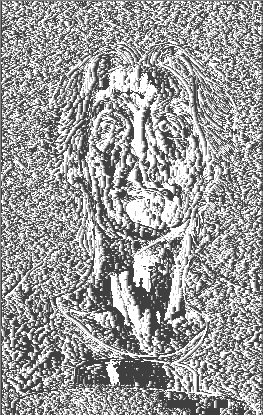

In [8]:
new_img += 2
new_img *= 1/new_img.max()
Image.fromarray((new_img*255).astype(np.uint8))